# NIRISS AMI: Binary fitting of AB Dor using AMICAL

## Introduction
This notebook takes a calibrated OIFITS file (see _Defining Terms_ below) from NIRISS Aperture Masking Interferometry (AMI) data of binary point source AB Dor and calibrator HD 37093. The data is simulated with Mirage ([Multi-Instrument Ramp Generator](https://mirage-data-simulator.readthedocs.io/en/latest/)), calibrated with the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/index.html), and has interferometric observables extracted using the Image Plane approach to Interferometric Analysis ([ImPlaneIA](http://ascl.net/1808.004)). This notebook estimates the parameters of a best-fit binary model for this data. It is closely based on Anthony Soulain's example script analyzing NIRISS AMI commissioning on the known binary AB Dor AC. 

We use AMICAL (Aperture Masking Interferometry Calibration and Analysis Library, developed by the Sydney Astrophotonic Instrumentation Lab) to extract binary point source parameters. AMICAL interfaces with the [CANDID (Companion Analysis and Non-Detection in Interferometric Data) analysis package](https://github.com/amerand/CANDID) analysis package, which is included with AMICAL. The CANDID code is described by [Galenne et al. 2015](https://ui.adsabs.harvard.edu/link_gateway/2015A&A...579A..68G/doi:10.1051/0004-6361/201525917). It utilizes model-fitting and chi-squared minimization. See the [CANDID github page](https://github.com/amerand/CANDID) for further details.

### Defining terms

**[OIFITS](https://doi.org/10.1051/0004-6361/201526405)** files are the Optical Interferometry standard FITS files used by the community. A science target's observables are **calibrated** by the observables of a PSF calibrator star's image, to remove telescope/instrument effects (as far as possible).

**AMICAL** is **A**perture **M**asking **I**nterferometry **C**alibration and **A**nalysis **L**ibrary.  It is developed by the Sydney Astrophotonic Instrumentation Lab [![version](http://img.shields.io/badge/AMICAL-v0.5dev-orange.svg?style=flat)](https://github.com/SydneyAstrophotonicInstrumentationLab/AMICAL.git)

**Developer Note:**

Create the conda environment needed to run this notebook by issuing the following command:
```
conda create -n <myenv> python=3.6
```
Activate the environment, install the requirements, and then open the notebook.

```
conda activate <myenv>
pip install -r pre-requirements.txt 
pip install -r requirements.txt 
jupyter notebook
```

***

## Imports

- *numpy* to handle array functions
- *scipy.ndimage* for image handling
- *multiprocessing* to parallelize binary extraction
- *astropy.io fits* for accessing FITS files
- *matplotlib.pyplot* for plotting data
- *zipfile* for accessing zip file
- *urllib.request* to access URL
- *amical* University of Sydney interferometric package for interface with CANDID high-contrast companion detection


In [1]:
%matplotlib inline

import numpy as np
import os
import glob
import multiprocessing

import zipfile
import urllib.request

from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import ndimage

import amical

***



The provided data is a NIRISS simulated dataset representing a binary star: a 4.61 $M_L$ K0V primary (AB Dor A) with a faint companion. At the date for which these data were simulated, we expect to observe the following characteristics of the binary system observed in filter F430M:  
- Magnitude difference: dm = 4.2 mag at 4.3 μm (a flux ratio of 48)
- Sub-λ/D separation: sep = 363.04 mas
- Position angle: theta = 285.40 degrees (from North)
  

In [2]:
# These are the binary parameters we expect CANDID to extract

sep = 363.04 # binary separation [mas]
theta = 285.398112 # position angle (pa) [deg]
dm = 4.2  # delta magnitude [mag]

## Loading data
Load the input data file. This is the science target's calibrated oifits file, created by running `2_niriss_ami_binary.ipynb`. The zipped file also includes a FITS image with the faint companion artificially brightened so we can examine its position relative to the host star.

In [3]:
# Download the products

boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/niriss_ami_binary/niriss_ami_binary3.zip'
boxfile = './niriss_ami_binary3.zip'

# Download zip file
if not os.path.exists(boxfile):
    urllib.request.urlretrieve(boxlink, boxfile)

    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()

In [4]:
# The data file is now in the current working directory
calib_oifits = glob.glob('calib*oifits')[0]
print(os.path.abspath(calib_oifits))



/user/rcooper/Projects/NIRISS/AMI/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/calib_ABDOR_NIRISS_g7s6_F480M_59670.0.0f.oifits


## File Information
The science target's calibrated oifits file needs to have interferometric observables corresponding to all possible baselines in the non-redundant mask, and their associated uncertainties. The uncertainty on each observable is taken to be the "straight" standard deviation (without consideration for linear dependence within a set of variables).
OIFITS files are multi-extension FITS binary tables.

The file contains seven extensions. The primary data extension is empty, and the remaining six extensions binary tables contain information about the observations and the interferometric data.
* **OI_WAVELENGTH**: Bandpass info (e.g. weighted central wavelength) 
* **OI_TARGET**: Properties of the target retrieved from SIMBAD, observation date and duration
* **OI_ARRAY**: Telescope info (e.g. sub-aperture locations, primary mirror diameter) 
* **OI_VIS**: Fringe visibility amplitudes and phases (calibrated visibility amplitudes of the target, corresponding to 21 baselines)
* **OI_VIS2**: Squared visibility amplitudes and phases (calibrated squared visibility of the target, corresponding to 21 baselines)
* **OI_T3**: Triple product amplitudes and phases (calibrated closure phases of the target corresponding to 35 triangles between sub-apertures)

In [5]:
# Display OIFITS file information
fits.info(calib_oifits)

Filename: calib_ABDOR_NIRISS_g7s6_F480M_59670.0.0f.oifits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  OI_WAVELENGTH    1 BinTableHDU     17   1R x 2C   [1E, 1E]   
  2  OI_TARGET     1 BinTableHDU     56   1R x 17C   [1I, 16A, 1D, 1D, 1E, 1D, 1D, 1D, 8A, 8A, 1D, 1D, 1D, 1D, 1E, 1E, 16A]   
  3  OI_ARRAY      1 BinTableHDU     34   7R x 7C   [16A, 16A, 1I, 1E, 3D, 1D, 6A]   
  4  OI_VIS        1 BinTableHDU     44   21R x 12C   [1I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 2I, 1L]   
  5  OI_VIS2       1 BinTableHDU     38   21R x 10C   [1I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 2I, 1L]   
  6  OI_T3         1 BinTableHDU     50   35R x 14C   [1I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 3I, 1L]   


The primary header tells us some information about the contents, such as the telescope (JWST), aperture mask design used (g7s6), the name of the target (AB Dor), and the name of the calibrator (HD37093):

In [6]:
# Display primary header contents
fits.getheader(calib_oifits)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2021-02-24'                                                          
ORIGIN  = 'Sydney University'                                                   
DATE-OBS= '2022-04-01T00:00:00.000'                                             
CONTENT = 'OIFITS2 '                                                            
TELESCOP= 'JWST    '                                                            
INSTRUME= 'NIRISS  '                                                            
OBSERVER= 'UNKNOWN '                                                            
OBJECT  = 'ABDOR   '                                                            
INSMODE = 'NRM     '        

## Examine the data

First, we will plot the interferometric observables we will be fitting with CANDID. These are the 35 closure phases and 21 squared visibilities of simulated AB Dor observations, calibrated by our reference star HD 37093. We will plot observables against $B_{max}/\lambda$, where $B_{max}$ is the baseline between the centers of two sub-apertures (for squared visibility) or the longest of the three baselines between three sub-apertures (for closure phase) and $\lambda$ is the central wavelength of the filter (4.82 $\mu$m)

In [7]:
# Your input data is an oifits file
with fits.open(calib_oifits) as hdu:
    cp_ext = hdu['OI_T3'].data
    sqvis_ext = hdu['OI_VIS2'].data
    oiarray = hdu['OI_ARRAY'].data
    wavel = hdu['OI_WAVELENGTH'].data['EFF_WAVE']
    pscale = hdu['OI_ARRAY'].header['PSCALE']
    pav3 = hdu[0].header['PA']
print('Wavelength: %.2e m' % wavel) 
print('V3 PA: %.2f degrees' % pav3)
cp = cp_ext['T3PHI']
cp_err = cp_ext['T3PHIERR']
tri_idx = cp_ext['STA_INDEX']

sqvis = sqvis_ext['VIS2DATA']
sqvis_err = sqvis_ext['VIS2ERR']
bl_idx = sqvis_ext['STA_INDEX']

hole_ctrs = oiarray['STAXYZ']
hole_idx = oiarray['STA_INDEX']

Wavelength: 4.82e-06 m
V3 PA: 108.12 degrees


In [8]:
# Calculate the length of the baseline [m] for each pair
baselines = []
for bl in bl_idx:
    hole1,hole2 = (bl[0] - 1), (bl[1] - 1) # because hole numbers start at 1
    x1, y1 = hole_ctrs[hole1][0], hole_ctrs[hole1][1] 
    x2, y2 = hole_ctrs[hole2][0], hole_ctrs[hole2][1] 
    length = np.abs(np.sqrt((x2 - x1)**2. + (y2 - y1)**2.))
    baselines.append(length)
# Calculate the length of three baselines for each triangle
# Select the longest for plotting
tri_baselines = []
tri_longest = []
for tri in tri_idx:
    hole1, hole2, hole3 = tri[0] - 1, tri[1] - 1, tri[2] - 1
    x1, y1 = hole_ctrs[hole1][0], hole_ctrs[hole1][1] 
    x2, y2 = hole_ctrs[hole2][0], hole_ctrs[hole2][1] 
    x3, y3 = hole_ctrs[hole3][0], hole_ctrs[hole3][1] 
    length12 = np.abs(np.sqrt((x2 - x1)**2. + (y2 - y1)**2.))
    length23 = np.abs(np.sqrt((x3 - x2)**2. + (y3 - y2)**2.))
    length31 = np.abs(np.sqrt((x1 - x3)**2. + (y1 - y3)**2.))
    tri_lengths = [length12,length23,length31]
    tri_baselines.append(tri_lengths)
    tri_longest.append(np.max(tri_lengths))
    
# Calculate B_max/lambda
bmaxlambda_sqvis = baselines / wavel
bmaxlambda_cp = tri_longest / wavel

# Label baselines and triangles
bl_strings = []
for idx in bl_idx:
    bl_strings.append(str(idx[0])+'_'+str(idx[1]))

tri_strings = []
for idx in tri_idx:
    tri_strings.append(str(idx[0])+'_'+str(idx[1])+'_'+str(idx[2]))

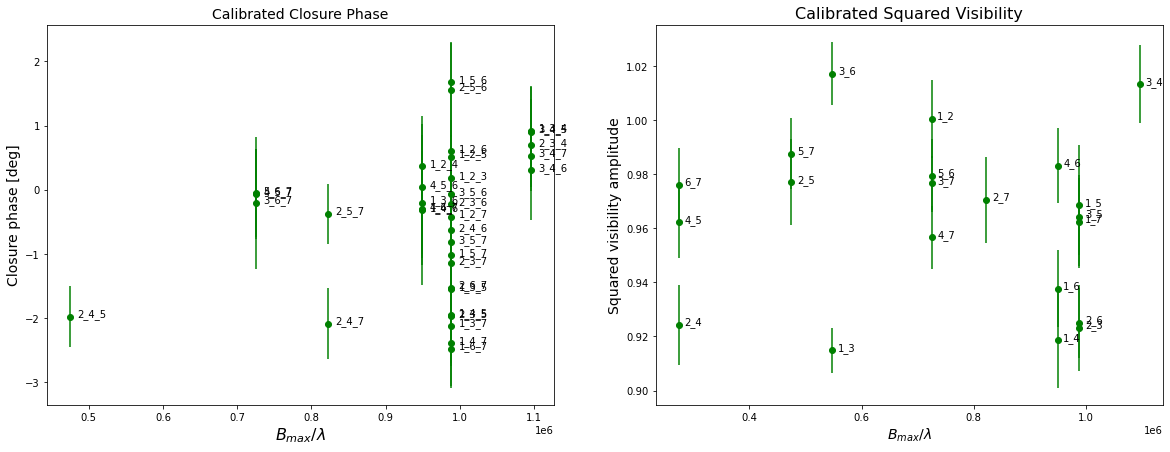

In [9]:
# Plot closure phases, square visibilities
# Label which point corresponds to which hole pair or triple

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))
ax1.errorbar(bmaxlambda_cp, cp, yerr=cp_err, fmt='go')
ax1.set_xlabel(r'$B_{max}/\lambda$',size=16)
ax1.set_ylabel('Closure phase [deg]',size=14)
ax1.set_title('Calibrated Closure Phase',size=14)
for ii, tri in enumerate(tri_strings):
    ax1.annotate(tri, (bmaxlambda_cp[ii], cp[ii]), xytext=(bmaxlambda_cp[ii]+10000, cp[ii]))
    
ax2.errorbar(bmaxlambda_sqvis, sqvis, yerr=sqvis_err, fmt='go')
ax2.set_title('Calibrated Squared Visibility',size=16)
ax2.set_xlabel(r'$B_{max}/\lambda$',size=14)
ax2.set_ylabel('Squared visibility amplitude',size=14)
for ii, bl in enumerate(bl_strings):
    ax2.annotate(bl, (bmaxlambda_sqvis[ii], sqvis[ii]), xytext=(bmaxlambda_sqvis[ii]+10000, sqvis[ii]))

The above plots show the calibrated closure phases (left) and the calibrated squared visibilities (right). Each quantity is plotted against $B_{max}/\lambda$, the baseline length divided by the wavelength of the observation. In the case of closure phases, where the triangle is formed by three baselines, the longest one is selected. 

For a monochromatic observation of a point source, we would expect all 35 closure phases to be zero, and all 21 squared visibilities to be unity. Asymmetries in the target caused by, e.g., an unresolved companion, cause the closure phases and visibilities corresponding to the baselines between affected sub-apertures to diverge from zero or unity. We can now use the set of calibrated observables to model the most probable location and contrast ratio of the companion. 

## Perform the binary parameter extraction

CANDID performs a search for faint companions over a coarse grid of starting points for the position of the companion and companion/star flux ratio. A multiparameter fit is performed for each starting position, and the companion position and flux ratio are adjusted, leading to a local $\chi^2$ minimum. Based on the distance each starting point must travel to reach the local minima, CANDID creates a finer search grid and repeats the process. This iterative process eventually identifies a global minimum in the  $\chi^2$ map.

Each point on the grid is fitted with a model of a resolved primary star with a point-source companion. The interferometric observables are estimated using a least-squares minimization between the data and model. 

CANDID also estimates the number of standard deviations for each point in the search grid, to produce an $n\sigma$ detection map. This map shows the significance of the binary detection over a model of a single resolved star. This value is capped at $50\sigma$. 

### Utilize the provided interface to the CANDID package
This function is an user friendly interface between the users of `amical`
pipeline and the `CANDID` analysis package (https://github.com/amerand/CANDID).

    Parameters:
    -----------
    `input_data` {str or list}:
        oifits file names or list of oifits files,\n
    `step` {int}:
        step used to compute the binary grid positions,\n
    `rmin`, `rmax` {float}:
        Bounds of the grid [mas],\n
    `diam` {float}:
        Stellar diameter of the primary star [mas] (default=0),\n
    `obs` {list}:
        List of observables to be fitted (default: ['cp', 'v2']),\n
    `doNotFit` {list}:
        Parameters not fitted (default: ['diam*']),\n
    `verbose` {boolean}:
        print some informations {default: False}.

    Outputs:
    --------
    `res` {dict}:
        Dictionary of the results ('best'), uncertainties ('uncer'),
        reduced chi2 ('chi2') and sigma detection ('nsigma').


 | --- Start CANDID fitting --- :
 | loading file calib_ABDOR_NIRISS_g7s6_F480M_59670.0.0f.oifits
 | observables available: [ 'cp', 't3', 'v2']
 | instruments: [ 'NIRISS']
 | best fit diameter (UD): 29.725 +- 3.113 mas (χ2 = 5.254)
 | Grid Fitting on 293 starting points (Pooling 12 processors): ... (it should take about 1 seconds)
 [=========================================================   ] 95%,     0 s (remaining)
 | Grid of fit took 2.0 seconds
 | current grid step (50.00mas) is too fine!!! --> 125.00mas should be enough


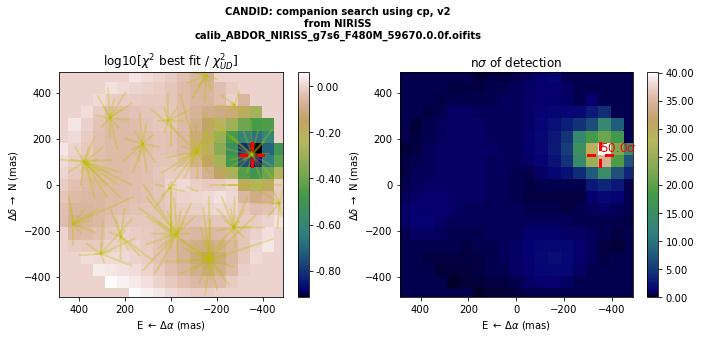


Results binary fit (χ2 = 0.4, nσ = 50.0):
-------------------
Sep = 375.4 +/- 3.0 mas
Theta = 290.3 +/- 0.5 deg
CR = 50.5 +/- 2.3
dm = 4.26 +/- 0.05


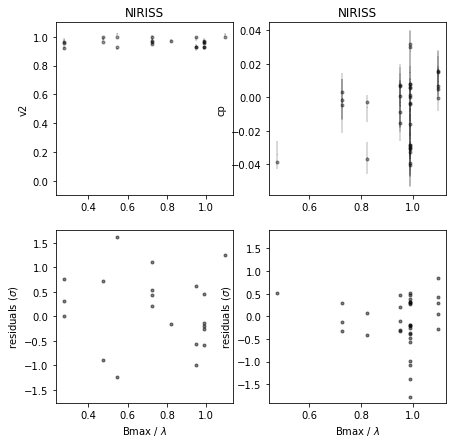

In [10]:
# Set up parameters for the binary search grid
param_candid = {'rmin': 10,  # inner radius of the grid
                'rmax': 500,  # outer radius of the grid
                'step': 50,  # grid sampling
                'ncore': multiprocessing.cpu_count()  # core for multiprocessing
                }
# Perform the fit
fit1 = amical.candid_grid(calib_oifits, **param_candid, diam=10, doNotFit=[])

In the above output, CANDID provides a best-fit angular size for the target star, 'best fit diameter (UD)', and the $\chi^2$ and n$\sigma$ (capped at 50$\sigma$) of the detection. It gives us estimates for the binary separation ('sep'), position angle ('theta'), contrast ratio ('CR'), and delta magnitudes ('dm'). 

It also produces plots of the squared visibilities and closure phases, and plots the residual (difference between the data and the best-fit model for each observable).

We can now compare these with our expected values from above:

In [11]:
sep_fit, sep_unc = fit1['best']['sep'], fit1['uncer']['sep']
theta_fit, theta_unc = fit1['best']['theta'], fit1['uncer']['theta']
dm_fit, dm_unc = fit1['best']['dm'], fit1['uncer']['dm']

print('             Expected      Model')
print('Sep [mas]:   %.3f      %.3f +/- %.2f' % (sep, sep_fit, sep_unc))
print('Theta [deg]: %.3f      %.3f +/- %.2f' % (theta, theta_fit, theta_unc))
print('dm [mag]:    %.3f        %.3f +/- %.2f' % (dm, dm_fit, dm_unc))

             Expected      Model
Sep [mas]:   363.040      375.448 +/- 3.03
Theta [deg]: 285.398      290.289 +/- 0.46
dm [mag]:    4.200        4.258 +/- 0.05


Next, we will use CANDID to find the detection limit at different angular separations. To do this, CANDID injects an additional companion at each grid position with different flux ratios and estimates the number of sigma for a theoretical detection at that point. It interpolates the flux ratio values at 3$\sigma$ for all points in the grid to produce a 3$\sigma$ detection map of the contrast (flux) ratio. 

 | --- Start CANDID contrast limit --- :
 | loading file calib_ABDOR_NIRISS_g7s6_F480M_59670.0.0f.oifits
 | observables available: [ 'cp', 't3', 'v2']
 | instruments: [ 'NIRISS']
 | observables: ['cp', 'v2'] from ['cp', 't3', 'v2']
 | instruments: ['NIRISS'] from ['NIRISS']
 | best fit diameter (UD): 0.001 +- 33993.755 mas (χ2 = 0.417)
 | Detection Limit Map 20x20 (Pooling 12 processors): ... it should take about 21 seconds
 | Method: injection
 [============================================================] 100%,     0 s (remaining)


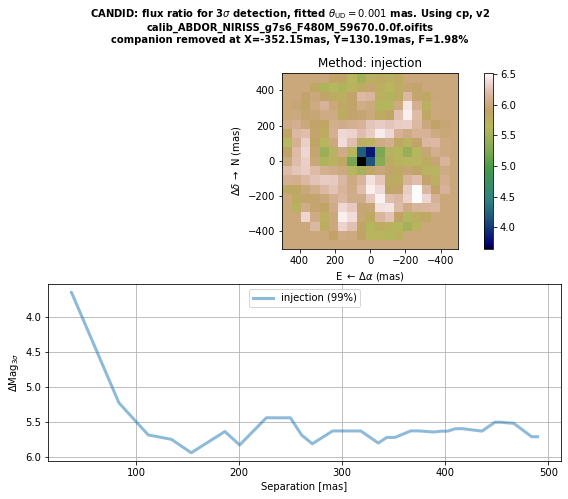

In [12]:
#  Find detection limits using the fake injection method
cr_candid = amical.candid_cr_limit(
            calib_oifits, **param_candid, fitComp=fit1['comp'])

The first plot above shows the detection limit, in terms of contrast ($\Delta$Mag), at each location in the search grid based on the injection/detection of false companions. The second plot show an estimate of the same detection limit with respect to the angular separation [mas] from the primary target. For a complete description of the CANDID algorithm, see [Galenne et al. 2015](https://ui.adsabs.harvard.edu/link_gateway/2015A&A...579A..68G/doi:10.1051/0004-6361/201525917).

### Visually compare the position

We can now look at an image with the faint companion artificially brightened, and we see that the position of the primary star at the center and its faint companion appear to match the position of the companion detected on the above $\chi^2$ and $n\sigma$ maps output by CANDID.

Text(0, 0.5, '$\\Delta\\delta$ [mas]')

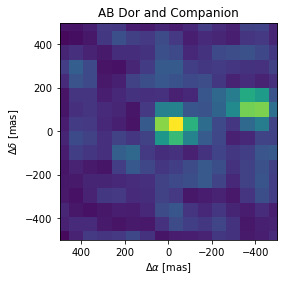

In [13]:
bright_im = fits.getdata('jw01093001001_01101_00001_nis_uncal_F480M_NRM_final_seed_image_fakemag_4.8131.fits')
# center and trim the image around the bright pixel before rotating
bright_idx = np.where(bright_im == np.max(bright_im))
left, right = bright_idx[1][0] - 30, bright_idx[1][0] + 30
down, up = bright_idx[0][0] - 30, bright_idx[0][0] + 30
trimmed = bright_im[down:up,left:right]

# rotate the image by pav3 to match orientation
rot_im = ndimage.rotate(trimmed, -pav3, reshape=False)
# convert image coordinates from pixels to milliarcsec, centered on target
xsize_px, ysize_px = rot_im.shape[0],rot_im.shape[1]
xsize_mas, ysize_mas = xsize_px*pscale, ysize_px*pscale
bright_loc = np.where(rot_im == np.max(rot_im))
brightx_mas, brighty_mas = bright_loc[1][0]*pscale, bright_loc[0][0]*pscale
xmin, xmax = 0. - brightx_mas, xsize_mas - brightx_mas
ymin, ymax = 0. - brighty_mas, ysize_mas - brighty_mas

# Plot the image on the same scale as CANDID maps above
fig = plt.figure(figsize=(4,4))
plt.imshow(rot_im, origin='lower', extent=[-xmin,-xmax,ymin,ymax])
plt.xlim([500,-500])
plt.ylim([-500,500])
plt.title('AB Dor and Companion')
plt.xlabel(r'$\Delta\alpha$ [mas]')
plt.ylabel(r'$\Delta\delta$ [mas]')



The above plot confirms the position of the faint companion relative to the target, shown here as change in right ascension and declination from the center of the target star.

## Additional Resources

- [JWST NIRISS AMI](https://jwst-docs.stsci.edu/near-infrared-imager-and-slitless-spectrograph/niriss-observing-modes/niriss-aperture-masking-interferometry)
- [CANDID paper (Galenne et al. 2015)](https://ui.adsabs.harvard.edu/link_gateway/2015A&A...579A..68G/doi:10.1051/0004-6361/201525917)

## About this notebook
**Author:** Rachel Cooper and Anand Sivaramakrishnan's transcription of an analysis script written by Anthony Soulain (University of Sydney) that runs the CANDID interferometric package  
**Updated On:** 2021-02-08

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 